In [1]:
import numpy as np
import pandas as pd 

import random
import sys
import matplotlib.pyplot as plt 
%matplotlib inline

sys.path.insert(1,'D:\\thesis-main\codes')
import time

from package.loadDb import *
from package.featureSelection_TENSORIZED import *
from package.featureSelection_TEMPORAL_PAGERANK import *
from package.featureSelection_SICE import *
from package.DiPCA.DIPCA import *
from package.trmf import *
from package.trmf_regressor import *

from package.regressors import *


## KAGGLE

In [2]:
# # import kaggle dataset
# address = "..\database\kaggleDataFrame"
# data_with_target= load_kaggle_dataframe(address+"\dataframes.csv")
# # data_with_target=data_with_target.iloc[2000:4000]
# data_without_target = data_with_target.drop(['DEMAND'],axis=1)
# target=data_with_target.iloc[:,-1]
# print("data with target size = ",data_with_target.shape )

## STOCK MARKET

In [3]:
# # data with target column
# address = "..\database\stock market dataset"
# data_with_target=load_stock_market_dataframe(address+"\sample_normalized_with_target.csv")
# # data_with_target=data_with_target.iloc[:10000]
# data_without_target = data_with_target.drop(['TARGET'],axis=1)
# # data_without_target=data_with_target.iloc[:,:-1]
# target=data_with_target.iloc[:,-1]

## appliances+energy+prediction

In [4]:
address = "..\\database\\appliances+energy+prediction\\energydata_complete.csv"
data_with_target =load_energydata_complete_dataframe(address)
# data_with_target=data_with_target.iloc[:2000]
data_without_target = data_with_target.drop(['Appliances'],axis=1)
target=data_with_target.iloc[:,0]
# data_with_target

In [5]:
data_without_target

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,...,17.033333,45.5300,6.600000,733.5,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
2016-01-11 17:10:00,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,...,17.066667,45.5600,6.483333,733.6,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2016-01-11 17:20:00,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,...,17.000000,45.5000,6.366667,733.7,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
2016-01-11 17:30:00,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,...,17.000000,45.4000,6.250000,733.8,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
2016-01-11 17:40:00,40,19.890000,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,...,17.000000,45.4000,6.133333,733.9,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.700000,45.590000,23.200000,...,23.200000,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.700000,45.590000,23.230000,...,23.200000,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.700000,45.730000,23.230000,...,23.200000,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117


## gas+sensor+array+temperature+modulation

In [6]:
# address='..\\database\\gas+sensor+array+temperature+modulation'
# filenamelist=['20160930_203718.csv', '20161001_231809.csv', '20161003_085624.csv', '20161004_104124.csv', 
#               '20161005_140846.csv', '20161006_182224.csv', '20161007_210049.csv', '20161008_234508.csv',
#               '20161010_095046.csv', '20161011_113032.csv', '20161013_143355.csv', '20161014_184659.csv',
#               '20161016_053656.csv']
# # Assuming the file name is in the format "20160930_203718.csv"
# filename = filenamelist[0]
# data=load_temperature_modulation(address,filename)

# data.head()


## gas+sensor+array+under+dynamic+gas+mixtures
### <!-- https://archive.ics.uci.edu/dataset/322/gas+sensor+array+under+dynamic+gas+mixtures -->

In [7]:
# address='..\\database\\gas+sensor+array+under+dynamic+gas+mixtures\\'
# file_path = 'ethylene_methane.txt'
# df = pd.read_csv(address+file_path, delim_whitespace=True)
# df.to_csv(address+"ethylene_methane.csv", index=False)

In [8]:

# address='..\\database\\gas+sensor+array+under+dynamic+gas+mixtures\\'
# filenamelist=["ethylene_CO.csv","ethylene_methane.csv"]
# filename = filenamelist[0]
# data=load_dynamic_gas_mixtures(address,filename)


# RUN

In [9]:
#segment sizes
interval=600
testSize=int(.2*interval)
#energy of pca to compute number of components
tol=.89
testSize

120

In [10]:
#dictionary contains rmse of test set of each segment for all methods
dict_rmse={}
dict_runtime={}

PCA

In [11]:
counter=0
pca_list=[]
num_comp_list=[]
runtime=[]
# while counter+interval <= data_without_target.shape[0]:
for i in range(data_without_target.shape[0]//interval):
    start_index=i*interval
    end_index=start_index+interval

    datacut=data_with_target[start_index:end_index]
    X_datacut=datacut.iloc[:,:-1]
    Y_datacut=datacut.iloc[:,-1]
    # print(counter,X_datacut.shape)
    st = time.time()
    X_transformed,eigenvalues=compute_pca(X_datacut,num_comp=None)
    et = time.time()
    num_comp=energy(eigenvalues,tol)
    X_pca=X_transformed[:,:num_comp]
    
    pca_rmse=xgboost_reg_error(X_pca,Y_datacut,testSize)

    pca_list.append(pca_rmse)##########################
    num_comp_list.append(num_comp)##########################

    elapsed_time = et - st
    runtime.append(elapsed_time)
    

    # counter+=interval
    
dict_rmse['PCA']=pca_list
dict_runtime["PCA_runtime"]=runtime

In [12]:
num_comp_list

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1]

In [14]:
DiPCA_rmse_list=[]
runtime=[]
s=1
counter=0
i=0
# while counter+interval <= data_without_target.shape[0]:
for j in range(data_without_target.shape[0]//interval):
    start_index=j*interval
    end_index=start_index+interval
    # K=num_comp_list[i]
    K=10
    data=data_without_target.to_numpy()
    data=data[start_index:end_index,:]
    
    target_cut=target.iloc[start_index:end_index]
    st=time.time()#>>>>>>>>>>>>>>>>>>>>>>
    data,_,_=autos(data)
    P, W, Theta, Ps, lambda_s, PHI_v, phi_v_lim, Ts2_lim, Qs_lim = DiPCA1(data, s, K)
    et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
    elapsed_time = et - st
    runtime.append(elapsed_time)

    # get reduced data
    new_features=transform_data(data, W[:, :K])
    # print(new_features.shape)
    rmse=xgboost_reg_error(new_features,target_cut,testSize)
    
    DiPCA_rmse_list.append(rmse)
    # counter+=interval
    i=i+1
    print(i,K)
    print("----------------------------------------------------------------------------")
dict_rmse['DiPCA_rmse']=DiPCA_rmse_list
dict_runtime["DiPCA_runtime"]=runtime


1 10
----------------------------------------------------------------------------
2 10
----------------------------------------------------------------------------
3 10
----------------------------------------------------------------------------
4 10
----------------------------------------------------------------------------
5 10
----------------------------------------------------------------------------
6 10
----------------------------------------------------------------------------
7 10
----------------------------------------------------------------------------
8 10
----------------------------------------------------------------------------
9 10
----------------------------------------------------------------------------
10 10
----------------------------------------------------------------------------
11 10
----------------------------------------------------------------------------
12 10
----------------------------------------------------------------------------
13 10
-------

In [15]:
dict_rmse

{'PCA': [0.5583932447951412,
  0.47556370925010105,
  0.651561603574057,
  0.5487860064805102,
  0.6422573994302875,
  0.6693265882515971,
  0.6516225788780481,
  0.5306340550020024,
  0.5348131285875158,
  0.5977637893349536,
  0.6860607791305039,
  0.6606104636149509,
  0.6573569212137775,
  0.6019106393244421,
  0.5474439988817295,
  0.631520255746736,
  0.4555005996558155,
  0.5781183672418959,
  0.6098832505613977,
  0.05435856222744331,
  0.6287625001853947,
  0.6260706942627685,
  0.6850979353574137,
  0.5924351690786374,
  0.5643499154403566,
  0.6064139634135696,
  0.6217374857926891,
  0.5044859549867068,
  0.6528536393675708,
  0.6453014617288455,
  0.5569346107926432,
  0.5886214544492824],
 'DiPCA_rmse': [0.6896968723207401,
  0.7784950650079238,
  0.49498607960889573,
  3.3461698475065544,
  0.9375187129379461,
  0.8226769356669059,
  0.6333226781200757,
  0.6458953910896432,
  1.2596793999001192,
  0.6951408290349819,
  0.8265027105514646,
  1.7546980437101434,
  0.72882

In [16]:
# DiPCA_rmse_list=[]
# runtime=[]
# a=10
# counter=0
# i=0
# # while counter+interval <= data_without_target.shape[0]:
# for j in range(data_without_target.shape[0]//interval):
#     start_index=j*interval
#     end_index=start_index+interval
    
#     K=num_comp_list[i]

#     data=data_without_target.to_numpy()
#     data=data[:,start_index:end_index]
#     target_cut=target.iloc[start_index:end_index]

#     st=time.time()#>>>>>>>>>>>>>>>>>>>>>>
#     data=autos(data)
#     P, W, Theta, Ps, lambda_s, PHI_v, phi_v_lim, Ts2_lim, Qs_lim = DiPCA1(data, K, a)
#     et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
#     elapsed_time = et - st
#     runtime.append(elapsed_time)

#     # get reduced data
#     new_features=transform_data(data, Ps)
#     print(new_features.shape)
#     rmse=xgboost_reg_error(new_features,target_cut,testSize)
    
#     DiPCA_rmse_list.append(rmse)
#     # counter+=interval
#     i=i+1
#     print(i,K)
#     print("----------------------------------------------------------------------------")
# dict_rmse['DiPCA_rmse']=DiPCA_rmse_list
# dict_runtime["DiPCA_runtime"]=runtime



## TRMF

In [17]:
# trmf parameters..............................................
lags = [1]
# K = 4######### changes besed on pca energy
lambda_f = .1
lambda_x = .1
lambda_w = .1
alpha = 10000
eta = .1
max_iteration=10000
# num_comp=K

In [18]:
trmf_rmse_list=[]
runtime=[]

counter=0
i=0
# while counter+interval <= data_without_target.shape[0]:
for j in range(data_without_target.shape[0]//interval):
    start_index=j*interval
    end_index=start_index+interval
    
    K=num_comp_list[i]

    data=data_without_target.to_numpy().T

    data=data[:,start_index:end_index]
    target_cut=target.iloc[start_index:end_index]

    T_train = data.shape[1]
    st=time.time()#>>>>>>>>>>>>>>>>>>>>>>
    data_normalized =normalized_data(data, T_train, 0, normalize=True)

    model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta)
    model.fit(data_normalized, max_iter = max_iteration)
    et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
    elapsed_time = et - st
    runtime.append(elapsed_time)

    # get reduced data
    new_features=model.X.T
    
    rmse=xgboost_reg_error(new_features,target_cut,testSize)
    
    trmf_rmse_list.append(rmse)
    # counter+=interval
    i=i+1
    print(i,K)
    print("----------------------------------------------------------------------------")
dict_rmse['trmf_rmse']=trmf_rmse_list
dict_runtime["TRMF_runtime"]=runtime


D:\thesis-main\codes\package\trmf.py:319: RuntimeWarning: overflow encountered in multiply
  X_l = self.X * W_l
D:\thesis-main\codes\package\trmf.py:297: RuntimeWarning: invalid value encountered in add
  grad_T_x = z_1 + z_2
D:\thesis-main\codes\package\trmf.py:322: RuntimeWarning: invalid value encountered in multiply
  z_2 = - (z_1 * np.roll(self.X, lag, axis=1)).sum(axis=1)


1 1
----------------------------------------------------------------------------


D:\thesis-main\codes\package\trmf.py:291: RuntimeWarning: overflow encountered in multiply
  X_l = self.X * W_l
D:\thesis-main\codes\package\trmf.py:298: RuntimeWarning: invalid value encountered in add
  return - 2 * np.dot(self.F.T, self.mask * (self.Y - np.dot(self.F, self.X))) + self.lambda_x * grad_T_x + self.eta * self.X


2 1
----------------------------------------------------------------------------


D:\thesis-main\codes\package\trmf.py:322: RuntimeWarning: overflow encountered in multiply
  z_2 = - (z_1 * np.roll(self.X, lag, axis=1)).sum(axis=1)


3 1
----------------------------------------------------------------------------
4 1
----------------------------------------------------------------------------
5 1
----------------------------------------------------------------------------


D:\thesis-main\codes\package\trmf.py:320: RuntimeWarning: invalid value encountered in subtract
  z_1 = self.X - np.roll(X_l, lag, axis=1)


6 1
----------------------------------------------------------------------------


D:\thesis-main\codes\package\trmf.py:294: RuntimeWarning: overflow encountered in multiply
  z_2 = - (np.roll(self.X, -lag, axis=1) - X_l) * W_l


7 1
----------------------------------------------------------------------------
8 1
----------------------------------------------------------------------------
9 2
----------------------------------------------------------------------------
10 1
----------------------------------------------------------------------------
11 1
----------------------------------------------------------------------------
12 1
----------------------------------------------------------------------------
13 1
----------------------------------------------------------------------------
14 1
----------------------------------------------------------------------------
15 2
----------------------------------------------------------------------------


## TEMPORAL PAGE RANK FEATURE SELECTION

In [ ]:
window_size_list=[2,3,5,7,10,30]#

In [ ]:
dict_mse_tpr={}
dict_runtime_tpr={}
for window_size in window_size_list :
    method_list = []
    runtime=[]

    # counter=0
    i=0
    # while counter+interval <= data_without_target.shape[0]:
    for j in range(data_without_target.shape[0]//interval):
        start_index=j*interval
        end_index=start_index+interval

        num_comp=num_comp_list[i]

        datacut=data_with_target[start_index:end_index]
        X_datacut=datacut.iloc[:,:-1]
        Y_datacut=datacut.iloc[:,-1]


        st=time.time()#>>>>>>>>>>>>>>>>>>>>>>
        
        arr=create_graph_details(X_datacut,window_size)
        a=featureSelection_tpr(arr,X_datacut.shape[1],num_comp)
       
        et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
        elapsed_time = et - st
        runtime.append(elapsed_time)


        mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)

        method_list.append(mse_tpr)
        #     print( "method_list",method_list)
        i=i+1
        # print(j)
        # print("----------------------------------------------------------------------------")
        # counter+=interval
    dict_mse_tpr["Temp-PR win={}".format(window_size)]=method_list
    dict_runtime_tpr["Temporal-PR win={}".format(window_size)]=runtime


dataframe_1 = pd.DataFrame(dict_mse_tpr)
dict_rmse['temp_PR_rmse']=list(dataframe_1.min(axis=1))
df_time_1=pd.DataFrame(dict_runtime_tpr)
dict_runtime["Temporal_pr_runtime"]=list(df_time_1.mean(axis=1))


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_7368\1583051420.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_7368\1583051420.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_7368\1583051420.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacu

## STATIC PR


In [ ]:
dict_mse_sice={}
dict_runtime_sice={}

for window_size in window_size_list:
    method_list = []
    runtime=[]

    # counter=0
    i=0
    # while counter+interval <= data_with_target.shape[0]:
    for j in range(data_without_target.shape[0]//interval):
        start_index=j*interval
        end_index=start_index+interval

        num_comp=num_comp_list[i]


        datacut=data_with_target[start_index:end_index]
        X_datacut=datacut.iloc[:,:-1]
        Y_datacut=datacut.iloc[:,-1]
        st=time.time()#>>>>>>>>>>>>>>>>>>>>>>

        selected_features_index=featureSelection(X_datacut,window_size)
        
        et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
        elapsed_time = et - st
        runtime.append(elapsed_time)
        
        selected_data= X_datacut[X_datacut.columns[selected_features_index]].to_numpy()
        mse_sice=xgboost_reg_error(selected_data[:,:num_comp],Y_datacut,testSize)
        

        method_list.append(mse_sice)
        #     print( "method_list",method_list)
        i=i+1
        print(counter/interval)
        print("----------------------------------------------------------------------------")
        counter+=interval
    dict_mse_sice["sice win={}".format(window_size)]=method_list
    dict_runtime_sice["Static-PR win={}".format(window_size)]=runtime

dataframe_2 = pd.DataFrame(dict_mse_sice)
dict_rmse['static_PR_rmse']=list(dataframe_2.min(axis=1))
df_time_2=pd.DataFrame(dict_runtime_sice)
dict_runtime["Static_pr_runtime"]=list(df_time_2.mean(axis=1))

number of windows= 300 
size of windows = 2
[0.07360740691808004, 0.07337488896103084, 0.07367307608531186, 0.07367315310292351, 0.07367307901704621, 0.07367310735689975, 0.07367309503200736, 0.0736730975318392, 0.07367307473957922, 0.07367311342026563, 0.07367315293191726, 0.07367289283017714, 0.07367237704082491, 0.07367310342583773, 0.07367309775426087, 0.07367309470156963, 0.07367311860347173, 0.07367310479785248, 0.07367310008756449, 0.07367307161435328, 0.07366481269493635, 0.07367310271869994, 0.07367312557565295, 0.07367284426527337, 0.07367233128284406, 0.07361783527565391, 0.07345640540909852] [3, 10, 22, 16, 9, 5, 17, 13, 21, 18, 14, 7, 6, 15, 4, 2, 8, 19, 11, 23, 12, 24, 20, 25, 0, 26, 1]
0.0
----------------------------------------------------------------------------
number of windows= 300 
size of windows = 2
[0.07366032873222936, 0.07347085701364522, 0.07368179100285975, 0.07368186563649524, 0.07368185823213519, 0.07368197247511632, 0.07368187395093297, 0.073681894313616

<AxesSubplot: title={'center': 'energy=0.89'}, xlabel='segments', ylabel='RMSE'>

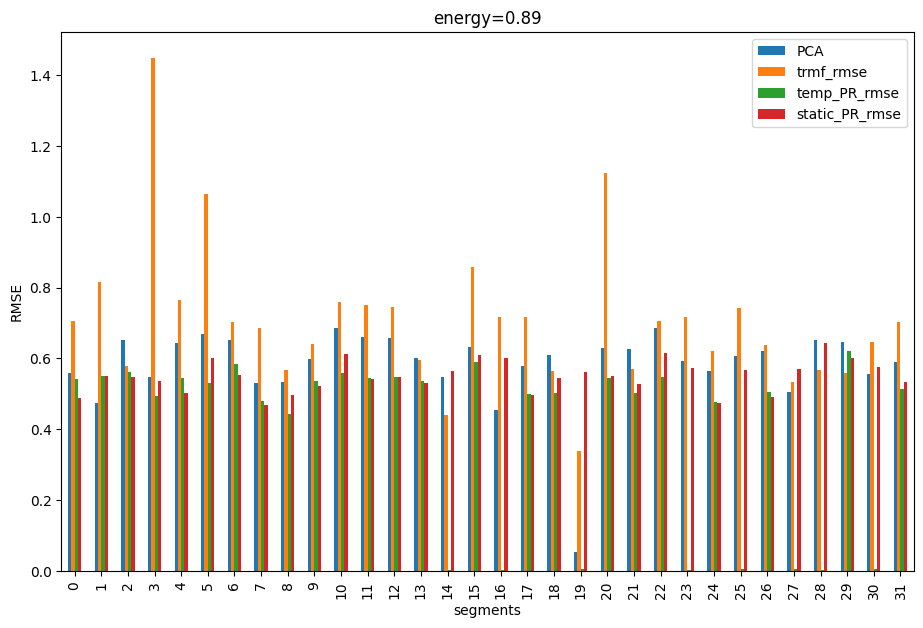

In [ ]:
   
dataframe = pd.DataFrame(dict_rmse)
plt.rcParams["figure.figsize"] = [11,7]
# dataframe.plot(kind="bar",title="num_comp={}".format("."),ylabel='RMSE',xlabel="dataframe segments")
dataframe.plot(kind="bar",title="energy={}".format(tol),ylabel='RMSE',xlabel="segments")


<AxesSubplot: title={'center': 'energy=0.89'}, xlabel='segments', ylabel='Time'>

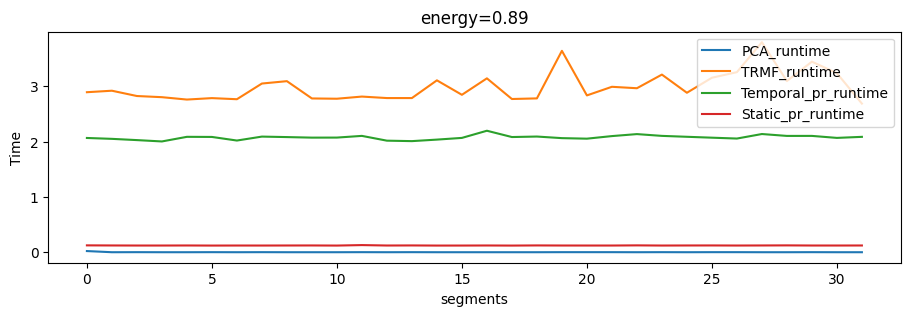

In [ ]:
time_dataframe = pd.DataFrame(dict_runtime)
plt.rcParams["figure.figsize"] = [11,3]
time_dataframe.plot(kind="line",title="energy={}".format(tol),ylabel='Time',xlabel="segments")


In [ ]:
time_dataframe = time_dataframe.rename(columns={'PCA_runtime': 'PCA','TRMF_runtime':'TRMF','Temporal_pr_runtime':'first-order similarities','Static_pr_runtime':'second-order similarities'})

time_dataframe

,PCA,TRMF,first-order similarities,second-order similarities
0,0.023936,2.892260,2.066000,0.126831
1,0.002992,2.919188,2.050042,0.124999
2,0.003990,2.823444,2.027447,0.123836
3,0.002993,2.802500,2.003157,0.123836
4,0.002993,2.759615,2.086600,0.124833
5,0.003990,2.785546,2.084602,0.123172
6,0.002993,2.765598,2.019609,0.124002
7,0.003989,3.048842,2.090736,0.123669
8,0.002990,3.091727,2.081957,0.124501
9,0.002992,2.779562,2.072145,0.125165


In [ ]:

time_dataframe.loc['Mean'] =list(time_dataframe.mean())


In [ ]:
num_comp_list

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1]

In [ ]:
dataframe = dataframe.rename(columns={'PCA': 'PCA','trmf_rmse':'TRMF','temp_PR_rmse':'first-order similarities','static_PR_rmse':'second-order similarities'})
dataframe

,PCA,TRMF,first-order similarities,second-order similarities
0,0.558393,0.705598,0.541361,0.489515
1,0.475564,0.816506,0.550956,0.550956
2,0.651562,0.579785,0.562094,0.547878
3,0.548786,1.449354,0.495052,0.535185
4,0.642257,0.763720,0.544208,0.503283
5,0.669327,1.065049,0.529744,0.602425
6,0.651623,0.703228,0.584359,0.553133
7,0.530634,0.686185,0.480097,0.467230
8,0.534813,0.568422,0.444060,0.496796
9,0.597764,0.640059,0.536778,0.522456


In [ ]:
dataframe.loc['Var'] =list(dataframe.var())
dataframe.loc['Mean'] =list(dataframe.mean())
dataframe.loc['Min'] =list(dataframe.min())
dataframe.loc['Max'] =list(dataframe.max())

In [ ]:
dataframe.head(30)


,PCA,TRMF,first-order similarities,second-order similarities
0,0.558393,0.705598,0.541361,0.489515
1,0.475564,0.816506,0.550956,0.550956
2,0.651562,0.579785,0.562094,0.547878
3,0.548786,1.449354,0.495052,0.535185
4,0.642257,0.763720,0.544208,0.503283
5,0.669327,1.065049,0.529744,0.602425
6,0.651623,0.703228,0.584359,0.553133
7,0.530634,0.686185,0.480097,0.467230
8,0.534813,0.568422,0.444060,0.496796
9,0.597764,0.640059,0.536778,0.522456


In [ ]:
import os

directory = r"D:\thesis-main\codes\experiments\appliances+energy+prediction__energy_data_complete_out"


# Create a subdirectory based on the 'tol' value
tol_directory = os.path.join(directory, str(tol)+"tuned trmf_dipca")
if not os.path.exists(tol_directory):
    os.makedirs(tol_directory)

# Define the filename with the desired format
name = "appliances_energy={}".format(tol)

# Save the time_dataframe to an Excel file
time_dataframe.to_excel(os.path.join(tol_directory, "time-{}.xlsx".format(name)))

# Save the dataframe to an Excel file
dataframe.to_excel(os.path.join(tol_directory, "RMSE-{}.xlsx".format(name)))

# Set plot size
plt.rcParams["figure.figsize"] = [29, 6]

# Plot time_dataframe and save
plot = time_dataframe[:-1].plot(kind="line", title="Feature Selection Time per Segment with energy={}".format(tol), ylabel='Time', xlabel="Segments")
plt.savefig(os.path.join(tol_directory, "plot_time-{}.png".format(name)))
plt.close()

# Plot RMSE dataframe and save
plot = dataframe[:-4].plot(kind="bar", title="RMSE Comparison of XGBoost Model After Feature Selection Using 4 Methods with energy={}".format(tol), ylabel='RMSE', xlabel="Segments")
plt.savefig(os.path.join(tol_directory, "plot_RMSE-{}.png".format(name)))
plt.close()

plot = dataframe[32:].plot(kind="bar", title="Summary Statistics of RMSE Comparison of XGBoost Model for Feature Selection Methods with energy={}".format(tol), ylabel='RMSE', xlabel="Segments")
plt.savefig(os.path.join(tol_directory, "plot_RMSE_Summary-{}.png".format(name)))
plt.close()

variables = {
    'Variable Name': ['address', 'interval', 'tol', 'testSize', 'num_comp_list', 'lags', 
                       'lambda_f', 'lambda_x', 'lambda_w', 'alpha', 'eta', 'max_iteration', 
                       'window_size_list'],
    'Value': [address, interval, tol, testSize, num_comp_list, lags, 
              lambda_f, lambda_x, lambda_w, alpha, eta, max_iteration, window_size_list]
}

# Create a DataFrame
df = pd.DataFrame(variables)

# Save to CSV
df.to_excel(os.path.join(tol_directory, 'variables.xlsx'), index=False)

In [ ]:
time_dataframe

,PCA,TRMF,first-order similarities,second-order similarities
0,0.023936,2.892260,2.066000,0.126831
1,0.002992,2.919188,2.050042,0.124999
2,0.003990,2.823444,2.027447,0.123836
3,0.002993,2.802500,2.003157,0.123836
4,0.002993,2.759615,2.086600,0.124833
5,0.003990,2.785546,2.084602,0.123172
6,0.002993,2.765598,2.019609,0.124002
7,0.003989,3.048842,2.090736,0.123669
8,0.002990,3.091727,2.081957,0.124501
9,0.002992,2.779562,2.072145,0.125165
